# Assignment 4: Customer Segmentation with Clustering

**Student Name:** [Leonardo Lopez]

**Date:** [2/20/2026]

---

## Assignment Overview

You've been hired as a data science consultant by a UK-based online gift retailer. They're spending the same amount on marketing to all customers regardless of value. Your task: segment their customer base using transaction data from 2009-2011, identify distinct customer groups, and provide actionable recommendations for each segment.

---

## Step 1: Import Libraries and Load Data

In [3]:
pip install pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\24leo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [4]:
# Load the Online Retail II dataset
# TODO: Load online_retail_II.csv from the data folder
df = pd.read_csv("data/online_retail_II.csv")  # Replace with pd.read_csv()

# Display basic information
# TODO: Display the first few rows and basic info about the dataset
print(df.head())
print("\nDataset Info:\n")
print(df.info())

print("\n" + "="*80)
print("CHECKPOINT: Verify dataset loaded correctly")
print(f"Dataset shape: {df.shape if df is not None else 'Not loaded'}")
print(f"Date range: [Check InvoiceDate column]")
print("="*80)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----

---
## Step 2: Aggregate Transaction Data to Customer-Level RFM Features

### Clean Transaction Data

Before aggregating to customer-level, clean the transaction data:
- Remove rows with missing Customer ID
- Remove returns (negative Quantity)
- Create TotalSpend column (Quantity × Price)
- Convert InvoiceDate to datetime

In [5]:
# Clean the data
# TODO: Remove missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# TODO: Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# TODO: Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']

# TODO: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\n" + "="*80)
print("CHECKPOINT: After data cleaning")
print(f"Remaining transactions: {len(df) if df is not None else 'N/A'}")
print(f"Unique customers: {df['Customer ID'].nunique() if df is not None else 'N/A'}")
print("="*80)


CHECKPOINT: After data cleaning
Remaining transactions: 805620
Unique customers: 5881


### Calculate RFM Features for Each Customer

Create three features for each customer:
- **Recency**: Days since last purchase (use December 10, 2011 as reference date)
- **Frequency**: Total number of unique invoices
- **Monetary**: Total amount spent

In [7]:
# Set reference date for recency calculation
reference_date = pd.to_datetime('2011-12-10')

# TODO: For each Customer ID, calculate:
# - Recency: (reference_date - max(InvoiceDate)).days
# - Frequency: count of unique Invoice numbers
# - Monetary: sum of TotalSpend

rfm_df = (df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days,
'Invoice': 'nunique','TotalSpend': 'sum'}).rename(columns={'InvoiceDate': 'Recency','Invoice': 'Frequency','TotalSpend': 'Monetary'}).reset_index())


print("\n" + "="*80)
print("CHECKPOINT: RFM Features Created")
if rfm_df is not None:
    print(f"Number of customers: {len(rfm_df)}")
    print(f"\nRFM Summary Statistics:")
    print(rfm_df.describe())
print("="*80)


CHECKPOINT: RFM Features Created
Number of customers: 5881

RFM Summary Statistics:
        Customer ID      Recency    Frequency       Monetary
count   5881.000000  5881.000000  5881.000000    5881.000000
mean   15314.674205   200.992858     6.287196    3017.076888
std     1715.429759   209.489651    13.012879   14734.128619
min    12346.000000     0.000000     1.000000       0.000000
25%    13833.000000    25.000000     1.000000     347.800000
50%    15313.000000    95.000000     3.000000     897.620000
75%    16797.000000   379.000000     7.000000    2304.180000
max    18287.000000   738.000000   398.000000  608821.650000


---
## Step 3: Standardize Features and Determine Optimal k

### Standardize RFM Features

K-means is sensitive to feature scale, so standardize features to mean=0, std=1

In [8]:
# TODO: Use StandardScaler to standardize Recency, Frequency, and Monetary
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])  # Replace with scaled features

print("\n" + "="*80)
print("CHECKPOINT: Features Standardized")
if rfm_scaled is not None:
    print(f"Scaled features shape: {rfm_scaled.shape}")
    print(f"Mean of scaled features: {rfm_scaled.mean(axis=0)}")
    print(f"Std of scaled features: {rfm_scaled.std(axis=0)}")
print("="*80)


CHECKPOINT: Features Standardized
Scaled features shape: (5881, 3)
Mean of scaled features: [ 9.18232408e-17 -2.77886123e-17  2.41640107e-18]
Std of scaled features: [1. 1. 1.]


### Elbow Method: Test k from 2 to 10

Calculate inertia (within-cluster sum of squares) for different values of k

In [9]:
# TODO: Test k values from 2 to 10
# For each k:
#   - Train KMeans(n_clusters=k, random_state=42)
#   - Store inertia value'
from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 11)

# Your code here
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertias.append(model.inertia_)

print("\n" + "="*80)
print("CHECKPOINT: Elbow Method Calculated")
print(f"Tested k values: {list(k_range)}")
print("="*80)


CHECKPOINT: Elbow Method Calculated
Tested k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]


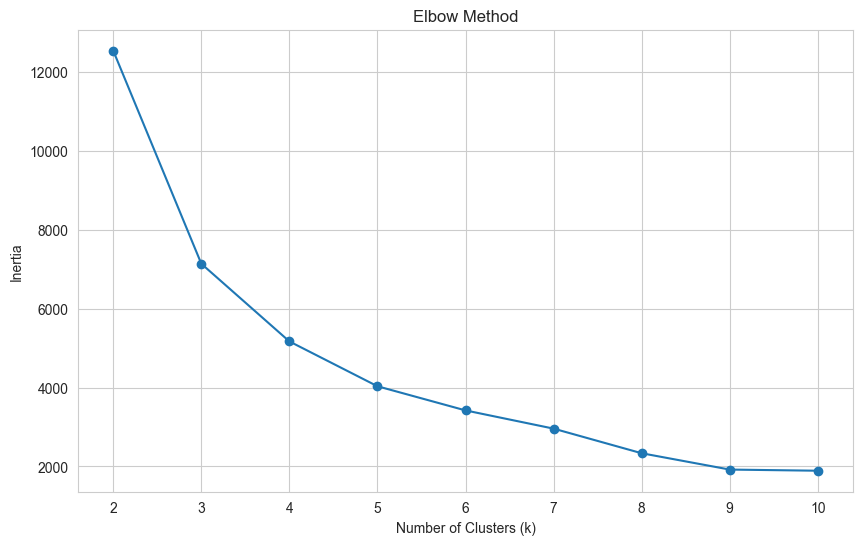

In [10]:
# TODO: Plot the elbow curve
# x-axis: k values
# y-axis: inertia
plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


### Silhouette Score Analysis

Calculate silhouette scores to validate cluster quality

In [11]:
# TODO: Calculate silhouette scores for k from 2 to 10
# For each k:
#   - Train KMeans
#   - Calculate silhouette_score(rfm_scaled, labels)

silhouette_scores = []

# Your code here
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

print("\n" + "="*80)
print("CHECKPOINT: Silhouette Scores Calculated")
print("="*80)


CHECKPOINT: Silhouette Scores Calculated


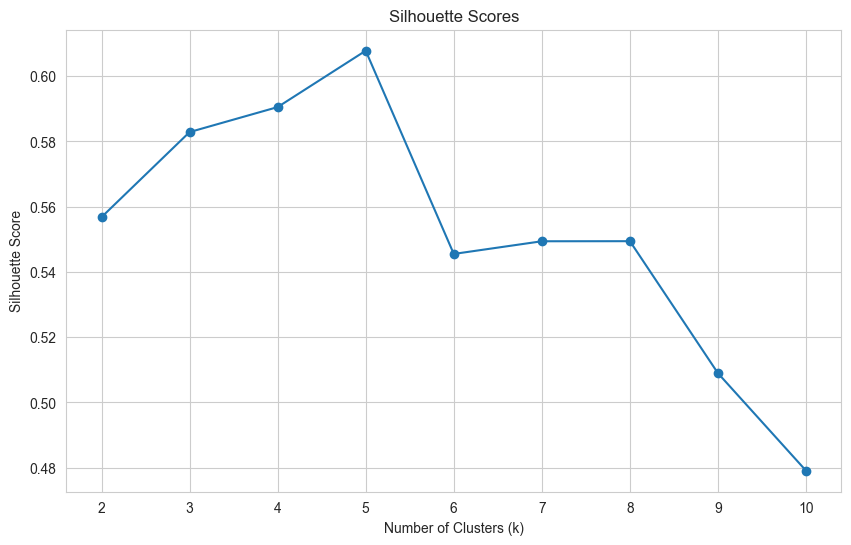

In [12]:
# TODO: Plot silhouette scores
# x-axis: k values
# y-axis: silhouette score
plt.figure()
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()


### Select Optimal k

**Your k selection justification (write 2-3 sentences):**

[The elbow plot showed a clear bend around k= 4 to 5. The silhouette scores increased steadily and reached their highest value at k=5 (0.61) showing the best cluster separation at this point.]

In [18]:
# TODO: Set your chosen k value
optimal_k = 5  # Replace with your chosen k (e.g., 4, 5, or 6)

print(f"Chosen k value: {optimal_k}")

Chosen k value: 5


---
## Step 4: Train K-Means Model and Visualize Segments

### Train Final K-Means Model

In [19]:
# TODO: Train KMeans with your optimal_k and random_state=42
kmeans = KMeans(n_clusters=optimal_k, random_state=42)  # Replace with trained model

# TODO: Add cluster labels to rfm_df
# rfm_df['Cluster'] = ...
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\n" + "="*80)
print("CHECKPOINT: K-Means Model Trained")
print(f"Number of clusters: {optimal_k}")
if 'Cluster' in rfm_df.columns:
    print(f"\nCluster sizes:")
    print(rfm_df['Cluster'].value_counts().sort_index())
print("="*80)


CHECKPOINT: K-Means Model Trained
Number of clusters: 5

Cluster sizes:
Cluster
0    3619
1    1929
2      17
3       2
4     314
Name: count, dtype: int64


### Visualize Customer Segments

Create a 2D scatter plot showing Frequency vs Monetary, colored by cluster

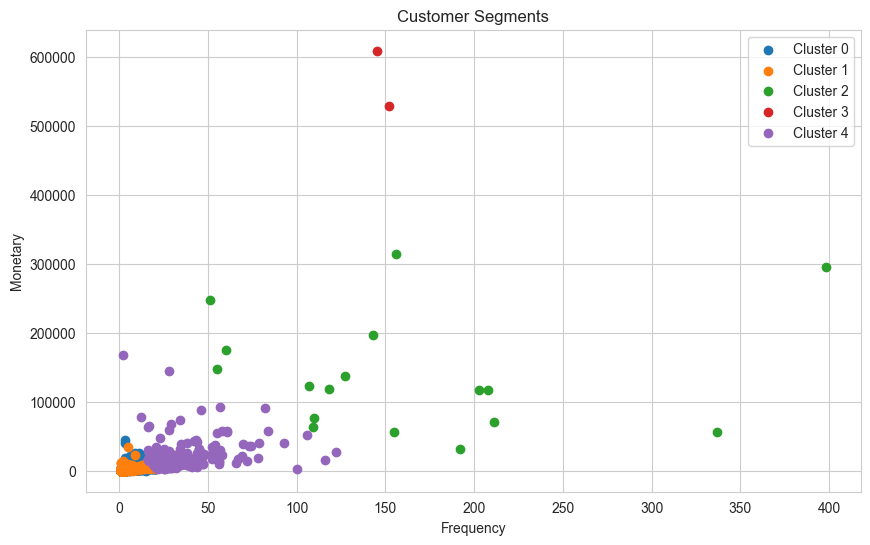

In [20]:
# TODO: Create scatter plot
# x-axis: Frequency
# y-axis: Monetary
# color: Cluster
# Include legend

plt.figure()
for cluster in sorted(rfm_df['Cluster'].unique()):
    subset = rfm_df[rfm_df['Cluster'] == cluster]
    plt.scatter(subset['Frequency'], subset['Monetary'], label=f'Cluster {cluster}')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.title('Customer Segments')
plt.show()


### Calculate Cluster Centers

Show the mean RFM values for each cluster

In [22]:
# TODO: Calculate mean Recency, Frequency, and Monetary for each cluster
cluster_summary = (rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())  # Replace with grouped DataFrame

print("\n" + "="*80)
print("CLUSTER CENTERS (Mean RFM Values)")
print("="*80)
# TODO: Display cluster_summary
print(cluster_summary)
print("="*80)


CLUSTER CENTERS (Mean RFM Values)
            Recency   Frequency       Monetary
Cluster                                       
0         73.795800    5.406190    2036.538555
1        469.925350    2.159150     752.396388
2         27.235294  161.176471  137806.995294
3          0.500000  148.500000  568712.085000
4         25.547771   32.509554   17330.192430


---
## Step 5: Interpret Segments and Provide Business Recommendations

### Segment 0: [Regular Customers]

**Customer Profile (3-5 sentences):**

[This segment has moderate recency -74 days, low frequency 5 purchases, and low monetary value $2,036. They purchase occasionally but do not spend big. They represent a large portion of customers, but these customers likely buy only needed. Marketing efforts could focus on increasing the frequency of purchases.]

In [23]:
# TODO: Calculate detailed statistics for Segment 0
# Show mean, median, min, max for R, F, M
segment_0 = rfm_df[rfm_df['Cluster'] == 0]
segment_0[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])

,Recency,Frequency,Monetary
mean,73.7958,5.40619,2036.538555
median,46.0000,4.00000,1180.230000
min,0.0000,1.00000,0.000000
max,283.0000,21.00000,44534.300000


### Segment 1: [Low Value Customers]

**Customer Profile (3-5 sentences):**

[This segment has very high recency -470 days, very low frequency 2 purchases, and low monetary value $752. They have not purchased in a long time and spend very little. This is the second largest group. These customers are likely churned. Reengagement campaigns seem like a good idea.]

In [24]:
# TODO: Calculate detailed statistics for Segment 1
segment_1 = rfm_df[rfm_df['Cluster'] == 1]
segment_1[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])

,Recency,Frequency,Monetary
mean,469.92535,2.15915,752.396388
median,434.00000,1.00000,376.920000
min,266.00000,1.00000,0.000000
max,738.00000,29.00000,34095.260000


### Segment 2: [High Value Loyal Customers]

**Customer Profile (3-5 sentences):**

[This segment has low recency 27 days, extremely high frequency 161 purchases, and very high monetary value -$137,807. They purchase frequently and spend heavily. Although this group is very small. These are extremely valuable customers and should be prioritized. Personalized offers and loyalty rewards would help this.]

In [25]:
# TODO: Calculate detailed statistics for Segment 2
segment_2 = rfm_df[rfm_df['Cluster'] == 2]
segment_2[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])

,Recency,Frequency,Monetary
mean,27.235294,161.176471,137806.995294
median,2.000000,143.000000,118628.080000
min,0.000000,51.000000,30861.060000
max,372.000000,398.000000,313946.370000


### Segment 3: [Top VIP Customers]

[This segment has extremely low recency 0.5 days, extremely high frequency -149 purchases, and the highest monetary value -$568,713. There are only 2 customers in this segment. These are the highest spending customers in the dataset. They represent exceptional revenue. They should receive exclusive treatment and a dedicated relationship.]

In [27]:
# TODO: Calculate detailed statistics for Segment 3
segment_3 = rfm_df[rfm_df['Cluster'] == 3]
segment_3[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])

,Recency,Frequency,Monetary
mean,0.5,148.5,568712.085
median,0.5,148.5,568712.085
min,0.0,145.0,528602.520
max,1.0,152.0,608821.650


### Segment 4: [Active High Spenders]

[This segment has low recency -26 days, high frequency -33 purchases, and high monetary value -$17,331). There are 314 customers in this group. They are active and spend significantly more than average customers. They are strong revenue contributors but not as extreme as Segment 2 or 3. Upselling and loyalty programs would likely increase their value even further.]

In [28]:
# TODO: Calculate detailed statistics for Segment 4
segment_4 = rfm_df[rfm_df['Cluster'] == 4]
segment_4[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])

,Recency,Frequency,Monetary
mean,25.547771,32.509554,17330.19243
median,8.500000,28.000000,12136.33000
min,0.000000,2.000000,1820.44000
max,497.000000,122.000000,168472.50000


---
## Business Recommendations

### Recommendation 1: [VIP Retention Program]

**Which segment(s) does this target?** [Segment 2 and Segment 3]

**Recommendation (3-5 sentences):**

[Segments 2 and 3 have extremely high value due to very high purchase frequency and very low recency. These customers are responsible for a disproportionate share of revenue but represent only 19 total customers. The company should implement a VIP loyalty program with personalized emails, exclusive early product access, and priority customer service.]

### Recommendation 2: [Reactivation Campaign]

**Which segment(s) does this target?** [Segment 1]

**Recommendation (3-5 sentences):**

[Segment 1 has extremely high recency meaning they have not purchased in a long time. They also have low frequency and low monetary value showing weak engagement. The company should launch a campaign to bring them back by using email and retargeting ads offering limited-time discounts or bundle deals.]

### Recommendation 3: [Upselling Strategy]

**Which segment(s) does this target?** [Segment 4 and Segment 0]

**Recommendation (3-5 sentences):**

[Segment 4 customers purchase frequently and spend significantly more than average, while Segment 0 represents the largest customer base with good activity. The company should use targeted product recommendations and bundle offers to increase order value. Email campaigns and personalized website recommendations would be good channels for this. For Segment 0 incentives to increase purchase frequency such as loyalty points or small discounts could move them toward higher value segments.]

---
## Step 6: Submit Your Work

Before submitting:
1. Make sure all code cells run without errors
2. Verify you have:
   - RFM features properly calculated
   - Elbow method and silhouette score visualizations
   - Written justification for your k selection
   - Customer segment scatter plot
   - Descriptive names and profiles for each segment
   - Three specific business recommendations
3. Check that all visualizations display correctly

Then push to GitHub:
```bash
git add .
git commit -m 'completed customer segmentation assignment'
git push
```

Submit your GitHub repository link on the course platform.